# Load file with train and test set.

In [2]:
train_set = pd.read_csv("./train.csv")
print("train set size: "+ str(np.shape(train_set)))
train_doc_ids = train_set["doc_id"]
train_labels  = train_set["label" ]

test_set  = pd.read_csv("./test.csv")
print("test set size:  "+ str(np.shape(test_set)))
test_doc_ids = test_set["doc_id"]

train set size: (100, 3)
test set size:  (48, 2)


For this sizes of train set it's unlikely we can do any sophisticated convolutional with embeddings model it is much less samples than it would be meaningfull. We have to fall back to bag of words. If I had more time I would consider using pre-trained embedding to count close neighbours of keywords to improve selection. If there was much more data I would use convolutional model. Slightly less data would be necessary if I was able to find some pre-trained german language model to be core of our predictor. As these pages has german text so we cant use easily some pre-trained english language model(e.g. BERT) at least not without massive amount of samples to adapt it into german.

# Load file with keywords and assigned cancer type, add more keywords.
I've browsed files with the most valuable label "3" to find what might be useful to add.

In [1]:
import pandas as pd
import numpy as np
keyword_df = pd.read_csv("keyword2tumor_type.csv")

custom_keywords = pd.DataFrame([["Tumorboard", "Tumorboard"],
                                ["Tumorboards", "Tumorboard"],
                                ["Tumorkonferenz", "Tumorboard"],
                                ["Tumorkonferenzen", "Tumorboard"],
                                ["Zweitmeinung", "Tumorboard"],
                                ["Leiter", "Tumorboard"],
                                ["Vertreter", "Tumorboard"],
                                ["Anmeldeschluss","Tag"],
                                ["Montag","Tag"],
                                ["Dienstag","Tag"],
                                ["Mittwoch","Tag"],
                                ["Donnerstag","Tag"],
                                ["Freitag","Tag"],
                                ["Samstag","Tag"],
                                ["Sonntag","Tag"],
                                ["Chirurg","Arze"],
                                ["Chirurgin","Artz"],
                                ["Onkologen","Artz"],
                                ["Onkologin","Artz"],
                                ["Dermatologe","Artz"],
                                ["Dermatologin","Artz"],
                                ["Gynäkologe","Artz"],
                                ["Gynäkologin","Artz"],
                                ["Urologe","Artz"],
                                ["Urologin","Artz"]
                               ],
                               
                                columns=["keyword", "tumor_type"])

keyword_df = keyword_df.append(custom_keywords)

print("number of keywords: " + str(np.shape(keyword_df)[0]))
print("number of categories: " + str(len(np.unique(keyword_df[["tumor_type"]]))))
#keyword_df = custom_keywords
#print(keyword_df)

number of keywords: 126
number of categories: 36


# Feature extraction
Lets extract some features for bag of words model. Helper functions implementing steps of pre-processing.

In [3]:
def filePathFromDocId(doc_id, data_dir="./htmls"):
    return data_dir+"/"+str(doc_id)+".html"

import html2text
def textFromHtml(html_str):
    html2textInstance = html2text.HTML2Text()
    html2textInstance.ignore_links=True
    html2textInstance.single_line_break = True
    text = html2textInstance.handle(html_str)
    return ' '.join(text.split())

import spacy
parser = spacy.load('de')
def tokenize(text):
    doc = parser(text)
    with doc.retokenize() as retokenizer:
        for ent in doc.ents:
            retokenizer.merge(doc[ent.start:ent.end], attrs={"LEMMA": ent.text})
    return [x.lemma_ for x in doc if not x.is_punct and not x.is_stop]

def countKeyWords(tokenized_str, keywords):
    return [(keyword, tokenized_str.count(keyword)) for keyword in keywords]

def categoryKeyWords(keyword_df, category):
    category_items = keyword_df["tumor_type"] == category
    return keyword_df["keyword"][category_items]

def within(item, container):
    for elem in container:
        if elem == item:
            return True
    return False

def sumSelectedKeyWordCounts(keyword_counts, keywords_to_sum):
    count_sum = 0
    for keyword, count in keyword_counts:
        if within(keyword, keywords_to_sum):
            count_sum = count_sum + count
    return count_sum
    
def aggregateKeyWordCountsByCategory(keyword_counts, keyword_df):

    unique_categories = np.unique(keyword_df["tumor_type"])
    ret = []
    for category in unique_categories:
        keywords_for_category = categoryKeyWords(keyword_df, category)
        category_count = sumSelectedKeyWordCounts(keyword_counts, keywords_for_category)
        ret.append((category, category_count))
    return ret

def tupleListAsDict_(tup, di): 
    di = dict(tup) 
    return di   

def tupleListAsDict(tuple_list):
    dictionary = {} 
    return (tupleListAsDict_(tuple_list, dictionary))


def extractFeaturesFromDoc(doc_id, keyword_df, use_keywords=False):
    filePath = filePathFromDocId(doc_id)
    fileHandle = open(filePath, "rb")
    doc = fileHandle.read().decode('utf-8',errors='ignore')
    doc = textFromHtml(doc)
    doc = tokenize(doc)
    features = []
    keyword_counts = countKeyWords(doc,keyword_df["keyword"])
    if use_keywords:
            return tupleListAsDict(keyword_counts)
    category_counts = aggregateKeyWordCountsByCategory(keyword_counts,keyword_df)
    return tupleListAsDict(category_counts)
    
def extractFeatures(doc_ids, keyword_df, use_keywords=False):
    feature_df = pd.DataFrame()
    for id_ in doc_ids:
         feature_df = feature_df.append(extractFeaturesFromDoc(id_, keyword_df, use_keywords), ignore_index = True)
    return feature_df

## For easier comparation store features based on bag of words and aggregated to categories

In [4]:
train_keyword_features = extractFeatures(train_doc_ids, keyword_df,True)
test_keyword_features = extractFeatures(test_doc_ids, keyword_df, True)

train_category_features = extractFeatures(train_doc_ids, keyword_df)
test_category_features = extractFeatures(test_doc_ids, keyword_df)

## Inspect shapes of extracted data

In [5]:
print(np.shape(train_category_features))
print(np.shape(test_category_features))

print(np.shape(train_keyword_features))
print(np.shape(test_keyword_features))

print(np.shape(train_labels))

(100, 40)
(48, 40)
(100, 151)
(48, 151)
(100,)


# Spliting labeled set to evaluate model and extracted features
Split this already thin dataset to test and learn to get insight into expected performance and check which features should be used.

In [6]:
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(
#train_category_features, train_labels, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
train_keyword_features, train_labels, test_size=0.3, random_state=42)

print(np.shape(X_train),np.shape(y_train))
print(np.shape(X_test),np.shape(y_test))

(70, 151) (70,)
(30, 151) (30,)


# Build and fit random forest model
As previously mentioned random forest was chosen for it's robustnes in dealing with large amount of features compared to amount of records.

In [7]:
from sklearn.ensemble import RandomForestClassifier
forest_model = RandomForestClassifier(n_estimators=100, class_weight = "balanced",random_state=42)
forest_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

# Evaluation
Evaluate using confusion matrix accuracy and weighted accuracy

In [8]:
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score
y_test_pred = forest_model.predict(X_test)
y_train_pred = forest_model.predict(X_train)

print(confusion_matrix(y_train,y_train_pred))
print(accuracy_score(y_train,y_train_pred))
print(balanced_accuracy_score(y_train,y_train_pred))

print(confusion_matrix(y_test,y_test_pred))
print(accuracy_score(y_test,y_test_pred))
print(balanced_accuracy_score(y_test,y_test_pred))


[[21  0  0]
 [ 1 42  0]
 [ 0  0  6]]
0.9857142857142858
0.9922480620155039
[[ 3  7  1]
 [ 1 15  0]
 [ 1  2  0]]
0.6
0.4034090909090909


class "3" is very underrepresented, additionaly I've checked these failing examples and in many cases it looks like they are falsely assigned this class.

## ROC AUC
To check whether model is better than chance evaluate results for each class using ROC curve and ROC AUC score

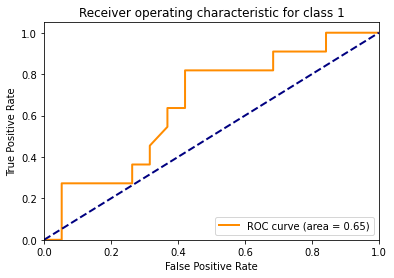

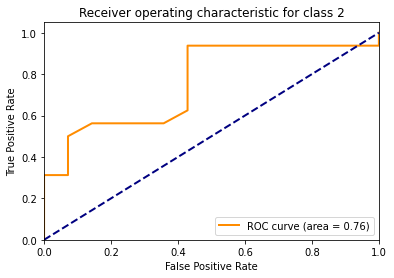

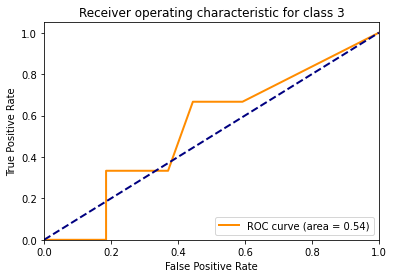

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

y_test_score  = forest_model.predict_proba(X_test)
y_train_score = forest_model.predict_proba(X_train)

y_test_one_hot = pd.get_dummies(y_test)
y_train_one_hot = pd.get_dummies(y_train)


fpr_1_test, tpr_1_test, _ = roc_curve(y_test_one_hot[1], y_test_score[:,0])
fpr_2_test, tpr_2_test, _ = roc_curve(y_test_one_hot[2], y_test_score[:,1])
fpr_3_test, tpr_3_test, _ = roc_curve(y_test_one_hot[3], y_test_score[:,2])

auc_1_test = roc_auc_score(y_test_one_hot[1], y_test_score[:,0])
auc_2_test = roc_auc_score(y_test_one_hot[2], y_test_score[:,1])
auc_3_test = roc_auc_score(y_test_one_hot[3], y_test_score[:,2])

#fpr_1_train, tpr_1_train, _ = roc_curve(y_train_one_hot[1], y_train_score[:,0])
#fpr_2_train, tpr_2_train, _ = roc_curve(y_train_one_hot[2], y_train_score[:,1])
#fpr_3_train, tpr_3_train, _ = roc_curve(y_train_one_hot[3], y_train_score[:,2])

#auc_1_train = roc_auc_score(y_train_one_hot[1], y_train_score[:,0])
#auc_2_train = roc_auc_score(y_train_one_hot[2], y_train_score[:,1])
#auc_3_train = roc_auc_score(y_train_one_hot[3], y_train_score[:,2])

def plotRoc(fpr, tpr, auc, classname):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for class '+classname)
    plt.legend(loc="lower right")
    plt.show()

# 
#plotRoc(fpr_1_train, tpr_1_train, auc_1_train, "1_train")
#plotRoc(fpr_2_train, tpr_2_train, auc_2_train, "2_train")
#plotRoc(fpr_3_train, tpr_3_train, auc_3_train, "3_train")

plotRoc(fpr_1_test, tpr_1_test, auc_1_test, "1")
plotRoc(fpr_2_test, tpr_2_test, auc_2_test, "2")
plotRoc(fpr_3_test, tpr_3_test, auc_3_test, "3")



As image shows model is slightly better than chance in predicting all of the classes. Class "3" is handled worse - mostly because of it's extremely low representation in set.

# Generate Submission file with final predictions
Teach final model with all avaliable marked samples to get best possible results for unlabeled set.

In [11]:
final_forest_model = RandomForestClassifier(n_estimators=100, class_weight = "balanced",random_state=42)

final_forest_model.fit(train_keyword_features, train_labels)

test_predicted_label = final_forest_model.predict(test_keyword_features)
output_data = pd.DataFrame() 
output_data["doc_id"] = test_doc_ids
output_data["prediction"] = pd.DataFrame(test_predicted_label)
output_data.to_csv("submission.csv",index=False)

# Expectations
Hopefully model will be performing slightly better than tests on part of labeled data - due to larger set which was used to train final model.

# What Would I do better if I had more time?
As I already mentioned I woudl use pre-trained word embeddings to capture closest neighbours of selected keywords.
If also it come with more data I would build convolutional model feed by these embeddings. I would also add cross-validation. If another model was used I would add model parameter optimization (grid search of cnn meta-parameters) based on this cross-validation.

# Issues with model
* Small dataset and poor balance makes teaching model difficult and renders lots of modern tools inadequate.
* Lack of cross-validation makes it difficult to accurately measure model accuracy.
* Low predictive power


# Performance evaluation
* Feature extraction is slow. To improve it's speed it would be possible to pre-process each files separately. To avoid bottleneck with IO files should be all read to memory before rest of processing, and intermediary steps should be stored to avoid using IO each time some tweaking in feature extraction.
* Training and prediction on  of model 12 core pc was almost instant - no need to improvement assuming keeping random forest as model. Otherwise (conv model) we need to keep it relatively simple to reduce use of resources.  
